### preprocess & manipulation, pre-analysis
 - lead, ozone, pm2.5

### imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import requests as rq
from urllib.request import urlopen
import json
import os
import pathlib
import plotly.express as px
%matplotlib inline

In [2]:
# pandas formatting 
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### functions

In [3]:
# functions

def FIPS_function(row):
    state = str(row['State Code']).zfill(2)
    county = str(row['County Code']).zfill(3)
    return str(state + county)
# convert to NO2 ug/m^3 for reference
def no2_mass_by_vol(ppb):
    ugm3 = 1.88*ppb
    return ugm3

def set_daily_cases_deaths(df):
    df['daily_new_cases'] = df['JHU_ConfirmedCases.data'].diff()
    df['daily_new_deaths'] = df['JHU_ConfirmedDeaths.data'].diff()
    return df

# plotting one day's avg 
def show_day_mean(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='Arithmetic Mean',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'Arithmetic Mean':'Arithmetic Mean (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig

# plotting one day's max value
def show_day_max(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='1st Max Value',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig  

def show_sites(df):
    fig = px.choropleth(df, geojson=counties, locations='fips', color='Parameter Code',
                               color_continuous_scale="Plasma",
                               range_color=(0, 1), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig

def get_counties_df(file_name='./data/covid/config/counties.json'):
    with open(file_name) as file:
                county_data = json.load(file)
    
    df = pd.DataFrame.from_dict(county_data)
    
    data = [df[col] for col in df.columns]    
    
    # pivot
    return pd.DataFrame(data,columns=df.index, index=df.columns)

def get_fips_from_county_lookup():
    counties = get_counties_df() 
    counties = counties.dropna(subset=['fips'])
    counties.fips = counties.fips.apply(lambda f: eval(str(f)).get('id'))
    counties_index = {k: v for k, v in zip(counties.index, counties.fips)}
    def get_fips_from_county(county):
        return counties_index[county]
    return get_fips_from_county

def avg_county_pollution(df, column_to_avg = "Arithmetic Mean", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
    # All days 
    # days = list(df[date_column].unique())
    # all_fips = list(df['fips'].unique())
    avg_by_day = df.groupby(['Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    return avg_by_day

def cols_missing(df):
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        pct = df[col].isna().mean() * 100
        if missing_vals != 0:
            print(f"{col} = {df[col].isnull().sum()}",'--','{} = {}%'.format(col, round(pct, 2)))
    if total == 0:
        print("no missing values left")
        
def print_outliers(df,col):
    print(col)
    #print(df[col].describe())
    print('Min: ',df[col].min())
    print('1st quartile: ',df[col].quantile(0.25))
    print('3rd quartile: ',df[col].quantile(0.75))
    print('Max: ',df[col].max())
    #print(sns.boxplot(x=df[col]))

In [183]:
##
def daily_avg_county_pollution(df, column_to_avg = "Arithmetic Mean", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
        avg_by_day = df.groupby([date_column,'fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    else:
        avg_by_day = df.groupby([date_column,'Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
        
        
    return avg_by_day

def daily_avg_county_pollution_lead(df, column_to_avg = "1st Max Value", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
        avg_by_day = df.groupby([date_column,'fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    else:
        avg_by_day = df.groupby([date_column,'Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
        
        
    return avg_by_day

### import data

In [5]:
#pm2.5 speciation
og_pm19 = pd.read_csv('data/daily_pm25_2019_FIPS.csv', dtype={'fips':'string'})
og_pm20 = pd.read_csv('data/daily_pm25_2020_FIPS.csv', dtype={'fips':'string'})
og_pm21 = pd.read_csv('data/daily_pm25_2021_FIPS.csv', dtype={'fips':'string'})

#ozone
og_ozone19 = pd.read_csv('data/daily_ozone_2019_FIPS.csv', dtype={'fips':'string'})
og_ozone20 = pd.read_csv('data/daily_ozone_2020_FIPS.csv', dtype={'fips':'string'})
og_ozone21 = pd.read_csv('data/daily_ozone_2021_FIPS.csv', dtype={'fips':'string'})

#lead
og_lead19 = pd.read_csv('data/daily_lead_2019_FIPS.csv', dtype={'fips':'string'})
og_lead20 = pd.read_csv('data/daily_lead_2020_FIPS.csv', dtype={'fips':'string'})
og_lead21 = pd.read_csv('data/daily_lead_2021_FIPS.csv', dtype={'fips':'string'})



####drop columns
cols_to_drop = ['Pollutant Standard','POC','Parameter Code','Parameter Name','Sample Duration'
               , 'Method Code','Method Name','City Name','Date of Last Change']

pm19 = og_pm19.drop(cols_to_drop, axis=1)
pm20 = og_pm20.drop(cols_to_drop, axis=1)
pm21 = og_pm21.drop(cols_to_drop, axis=1)

ozone19 = og_ozone19.drop(columns=cols_to_drop,axis=1)
ozone20 = og_ozone20.drop(columns=cols_to_drop,axis=1)
ozone21 = og_ozone21.drop(columns=cols_to_drop,axis=1)

lead19 = og_lead19.drop(columns=cols_to_drop,axis=1)
lead20 = og_lead20.drop(columns=cols_to_drop,axis=1)
lead21 = og_lead21.drop(columns=cols_to_drop,axis=1)

In [7]:
#no2_20['Date Local'] = pd.to_datetime(no2_20['Date Local'], format="%Y/%m/%d")

pm19['Date Local'] = pd.to_datetime(pm19['Date Local'], format="%Y/%m/%d")
pm20['Date Local'] = pd.to_datetime(pm20['Date Local'], format="%Y/%m/%d")
pm21['Date Local'] = pd.to_datetime(pm21['Date Local'], format="%Y/%m/%d")

ozone19['Date Local'] = pd.to_datetime(ozone19['Date Local'], format="%Y/%m/%d")
ozone20['Date Local'] = pd.to_datetime(ozone20['Date Local'], format="%Y/%m/%d")
ozone21['Date Local'] = pd.to_datetime(ozone21['Date Local'], format="%Y/%m/%d")

lead19['Date Local'] = pd.to_datetime(lead19['Date Local'], format="%Y/%m/%d")
lead20['Date Local'] = pd.to_datetime(lead20['Date Local'], format="%Y/%m/%d")
lead21['Date Local'] = pd.to_datetime(lead21['Date Local'], format="%Y/%m/%d")

### daily avg

In [184]:
#pm
daily_avg_pm19 = daily_avg_county_pollution(pm19)
daily_avg_pm20 = daily_avg_county_pollution(pm20)
daily_avg_pm21 = daily_avg_county_pollution(pm21)

#ozone
daily_avg_ozone19 = daily_avg_county_pollution(ozone19)
daily_avg_ozone20 = daily_avg_county_pollution(ozone20)
daily_avg_ozone21 = daily_avg_county_pollution(ozone21)

#lead
daily_avg_lead19 = daily_avg_county_pollution(lead19)
daily_avg_lead20 = daily_avg_county_pollution(lead20)
daily_avg_lead21 = daily_avg_county_pollution(lead21)

In [185]:
daily_avg_pm20.head(2)

Arithmetic Mean  1st Max Value   AQI
Date Local fips                                       
2020-01-01 01003             11.6           11.6  48.0
           01049              7.0            7.0  29.0

In [186]:
daily_avg_ozone20.head(2)

Arithmetic Mean  1st Max Value  AQI
Date Local fips                                      
2020-01-01 01049         0.036529          0.041   38
           01073         0.030824          0.034   31

In [187]:
daily_avg_lead20.head(2)

Arithmetic Mean  1st Max Value  AQI
Date Local fips                                      
2020-01-01 06037            0.008          0.009  NaN
           26163            0.014          0.014  NaN

In [10]:
#pm19_county_mean= pm19.groupby(['Date Local','fips']).agg({'Arithmetic Mean':'mean'})
#ozone19_county_mean= ozone19.groupby(['Date Local','fips']).agg({'Arithmetic Mean':'mean'})
#lead19_county_mean= lead19.groupby(['Date Local','fips']).agg({'Arithmetic Mean':'mean'})

In [11]:
#pm19_county_means = avg_county_pollution(pm19).drop(['1st Max Value'],axis=1).reset_index().groupby(['fips']).mean()
#ozone19_county_means = avg_county_pollution(ozone19).drop(['1st Max Value'],axis=1).reset_index().groupby(['fips']).mean()
#lead19_county_means = avg_county_pollution(lead19).reset_index().groupby(['fips']).mean()

### county means

In [188]:
#pm
county_means_pm19 = daily_avg_pm19.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_pm20 = daily_avg_pm20.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_pm21 = daily_avg_pm21.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)

#ozone
county_means_ozone19 = daily_avg_ozone19.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_ozone20 = daily_avg_ozone20.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_ozone21 = daily_avg_ozone21.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)


#shoudl do avgs for 1st max

#lead
county_means_lead19 = daily_avg_lead19.reset_index().groupby(['fips']).mean().drop(['AQI'],axis=1)
county_means_lead20 = daily_avg_lead20.reset_index().groupby(['fips']).mean().drop(['AQI'],axis=1)
county_means_lead21 = daily_avg_lead21.reset_index().groupby(['fips']).mean().drop(['AQI'],axis=1)

In [189]:
county_means_pm20.head(2)

,Arithmetic Mean,AQI
fips,,
01003,7.846903,32.345133
01027,6.784259,27.833333


In [190]:
county_means_ozone20.head(2)

,Arithmetic Mean,AQI
fips,,
01003,0.028291,33.508547
01049,0.030688,34.573770


In [191]:
county_means_lead20.head(2)

,Arithmetic Mean,1st Max Value
fips,,
01109,0.072311,0.075033
04007,0.011845,0.019217


### convert to dictionary

In [192]:
# pm25
county_means_pm19.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_pm20.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_pm21.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)

county_benchmarks_pm19 = county_means_pm19.to_dict('index')
county_benchmarks_pm20 = county_means_pm20.to_dict('index')
county_benchmarks_pm21 = county_means_pm21.to_dict('index')


# ozone
county_means_ozone19.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_ozone20.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_ozone21.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)

county_benchmarks_ozone19 = county_means_ozone19.to_dict('index')
county_benchmarks_ozone20 = county_means_ozone20.to_dict('index')
county_benchmarks_ozone21 = county_means_ozone21.to_dict('index')


# lead
county_means_lead19.rename(columns={'Arithmetic Mean':'mean_ppb','1st Max Value':'mean_max'},inplace=True)
county_means_lead20.rename(columns={'Arithmetic Mean':'mean_ppb','1st Max Value':'mean_max'},inplace=True)
county_means_lead21.rename(columns={'Arithmetic Mean':'mean_ppb','1st Max Value':'mean_max'},inplace=True)

county_benchmarks_lead19 = county_means_lead19.to_dict('index')
county_benchmarks_lead20 = county_means_lead20.to_dict('index')
county_benchmarks_lead21 = county_means_lead21.to_dict('index')

In [194]:

def check_level(df, averages, delta=0):
    """Return dictonary with higher than average ppb for each fips code.
    
    
    Parameters:
    
    df -- single full dataframe
    averages -- dict of structure fips:(mean_ppb, AQI)
    delta -- ppb difference to flag, default = 0
    
    The averages dictionary should have one entry per fips code, 
            giving the average concentration for that county.
    
    Return:
    peaks -- dict of structure fips:[dates]
    """
    
    targets = {}
    for fipc in list(averages.keys()):
        df[df['fips']==fipc]
        peak_df = df[(df['fips']==fipc) & (df['Arithmetic Mean'] >= (averages[fipc]['mean_ppb'] + delta))]
        targets[fipc] = peak_df[['Date Local','Arithmetic Mean']].to_dict()
    return targets

In [195]:
##flats

#pm
flat_daily_avg_pm19 = daily_avg_pm19.reset_index()
flat_daily_avg_pm20 = daily_avg_pm20.reset_index()
flat_daily_avg_pm21 = daily_avg_pm21.reset_index()

#ozone
flat_daily_avg_ozone19 = daily_avg_ozone19.reset_index()
flat_daily_avg_ozone20 = daily_avg_ozone20.reset_index()
flat_daily_avg_ozone21 = daily_avg_ozone21.reset_index()

#lead
flat_daily_avg_lead19 = daily_avg_lead19.reset_index()
flat_daily_avg_lead20 = daily_avg_lead20.reset_index()
flat_daily_avg_lead21 = daily_avg_lead21.reset_index()

### cross ref keys

In [196]:
#pm19
to_cross_ref_pm19 = check_level(flat_daily_avg_pm19,county_benchmarks_pm19,delta=15)
to_cross_ref_pm20 = check_level(flat_daily_avg_pm20,county_benchmarks_pm20,delta=15)
to_cross_ref_pm21 = check_level(flat_daily_avg_pm21,county_benchmarks_pm21,delta=15)

pm19_cref_keys = list(to_cross_ref_pm19.keys())
pm20_cref_keys = list(to_cross_ref_pm20.keys())
pm21_cref_keys = list(to_cross_ref_pm21.keys())

#ozone
to_cross_ref_ozone19 = check_level(flat_daily_avg_ozone19,county_benchmarks_ozone19,delta=15)
to_cross_ref_ozone20 = check_level(flat_daily_avg_ozone20,county_benchmarks_ozone20,delta=15)
to_cross_ref_ozone21 = check_level(flat_daily_avg_ozone21,county_benchmarks_ozone21,delta=15)

ozone19_cref_keys = list(to_cross_ref_ozone19.keys())
ozone20_cref_keys = list(to_cross_ref_ozone20.keys())
ozone21_cref_keys = list(to_cross_ref_ozone21.keys())


#lead 
to_cross_ref_lead19 = check_level(flat_daily_avg_lead19,county_benchmarks_lead19,delta=15)
to_cross_ref_lead20 = check_level(flat_daily_avg_lead20,county_benchmarks_lead20,delta=15)
to_cross_ref_lead21 = check_level(flat_daily_avg_lead21,county_benchmarks_lead21,delta=15)

lead19_cref_keys = list(to_cross_ref_lead19.keys())
lead20_cref_keys = list(to_cross_ref_lead20.keys())
lead21_cref_keys = list(to_cross_ref_lead21.keys())

In [197]:
#pm cref counts
print('pm19 keys to cref: ', len(pm19_cref_keys))
print('pm20 keys to cref: ', len(pm20_cref_keys))
print('pm21 keys to cref: ', len(pm21_cref_keys))

#ozone cref counts
print('\nozone19 keys to cref: ', len(ozone19_cref_keys))
print('ozone20 keys to cref: ', len(ozone20_cref_keys))
print('ozone21 keys to cref: ', len(ozone21_cref_keys))

#lead cref counts
print('\nlead19 keys to cref: ', len(lead19_cref_keys))
print('lead20 keys to cref: ', len(lead20_cref_keys))
print('lead21 keys to cref: ', len(lead21_cref_keys))

pm19 keys to cref:  634
pm20 keys to cref:  626
pm21 keys to cref:  308

ozone19 keys to cref:  776
ozone20 keys to cref:  767
ozone21 keys to cref:  408

lead19 keys to cref:  80
lead20 keys to cref:  71
lead21 keys to cref:  19


# -----------------------------------------
    - began side look at the bottom for given fips

In [205]:
# Collect list of dates for the target county
target_fips = '06075' #sanfran 06075 #denver 08031

#pm
pm20_dates = list(to_cross_ref_pm20[target_fips]['Date Local'].values())
print('pm data count: ', len(pm20_dates))

#ozone
ozone20_dates = list(to_cross_ref_ozone20[target_fips]['Date Local'].values())
print('ozone data count: ', len(ozone20_dates))

#lead
lead20_dates = list(to_cross_ref_lead20[target_fips]['Date Local'].values())
print('lead data count: ', len(lead20_dates))

pm data count:  15
ozone data count:  0
lead data count:  0


# --------------------------------------


# covid functions

In [211]:
def load_covid_by_fips(fipcode):
    df = pd.read_pickle(NOAH_WKDIR.joinpath("processed_data","county_merged_parts",get_county_from_fips(fipcode)+'.pkl'))   
    return df
clamped_covid = ['fips','JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                 'latestTotalPopulation','MaleAndFemale_AtLeast65_Population.data',
                 'Male_Total_Population.data','Female_Total_Population.data',
                 'MaleAndFemale_Under18_Population.data','BLS_EmployedPopulation.data',
                 'BLS_UnemployedPopulation.data','BLS_UnemploymentRate.data',
                 'BLS_LaborForcePopulation.data','AverageWindDirection.data',
                ]

def stringify_fips(row):
    ''' Convert the INTeger representation of fips to a string with leading zeros.
            intended to be used in a lamda function.
            
    Arguments:
    
    row - a single row of a dataframe. Intended to be used like "df4.apply(lambda row: stringify_fips(row), axis=1)"
    
    '''
    strFips = str(row['fips']).zfill(5)
    return strFips

def rolling_cases(df, window_size=7):
    df['1wkroll'] = df['daily_new_cases'].rolling(window=window_size).mean()
    df.reset_index(inplace=True)
    df.set_index("dates",inplace = True)
    return df

# cases / 100,000 people
def set_weighted_cases(df):
    wpop =  df['latestTotalPopulation'].max()/100000
    z = df.loc[:,'JHU_ConfirmedCases.data'] / wpop
    df['total_cases_per_100k'] = z.values    
    return df

#deaths per person infected
def set_death_per_cases(df):
    df.loc[:,'deaths_per_cases']= np.where((df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data'])>=0,
                                          (df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data']), 0)
    return df

In [212]:

def save_if_not(df, fip):
    # if *fip* not found in 'my_savedir' then save it correctly
    pass


def load_and_augment_fips(fips):
    tdf = load_covid_by_fips(fips)
    # pickle loads numbers as floats; converting fips to int
    tdf['fips'] = tdf.apply(lambda row: math.floor(row['fips']), axis=1)

    # Making fips a string to match on other datasets with leading zero
    df2= tdf.astype({"fips":"int"}).astype({'fips':'string'})
    
    # adding leading zero where needed
    df2['fips'] = df2.apply(lambda row: stringify_fips(row), axis=1)
    
    #need daily change in cases to get the rolling delta of new infections
    df2 = set_daily_cases_deaths(df2)
    df2 = rolling_cases(df2)
    df2.index = pd.to_datetime(df2.index, format="%Y/%m/%d")
    top_level_covid = ['fips','daily_new_cases','daily_new_deaths', "1wkroll",
                   'JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                   'latestTotalPopulation']
    
    
    df3 = df2[top_level_covid].copy()
    df3 = set_weighted_cases(df3)
    df3 = set_death_per_cases(df3)
    
    del df2
    del tdf
    
    
    
    return df3

In [213]:
# function to pull from url

def pull_covid_data_BY_fips(fips):
    return df


#temp function to pull from work directory

def pull_covid_data_by_fips(name):
    df = pd.read_pickle(name)
    return df

In [234]:
#### somethings up with pickel ####
denver_covid = pd.read_pickle('Denver_Colorado_UnitedStates.pkl')

AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/internals/blocks.py'>

In [389]:
os.getcwd()

'/Users/evanfalkowski/Documents/Drexel/Capstone/DSCI_591'

## check with one county

In [214]:
###### specifiy fips code
fips_target = '01073'

In [215]:
to_cross_ref_pm20[fips_target]
#to_cross_ref_ozone20[fips_target]
#to_cross_ref_lead20[fips_target]

{'Date Local': {88846: Timestamp('2020-06-26 00:00:00'),
  89436: Timestamp('2020-06-27 00:00:00'),
  123819: Timestamp('2020-09-03 00:00:00'),
  141589: Timestamp('2020-10-08 00:00:00'),
  173142: Timestamp('2020-12-09 00:00:00'),
  173610: Timestamp('2020-12-10 00:00:00')},
 'Arithmetic Mean': {88846: 35.462962999999995,
  89436: 25.924999999999997,
  123819: 25.31354175,
  141589: 26.729166499999998,
  173142: 26.6204545,
  173610: 25.4125}}

In [216]:
to_cross_ref_ozone20[fips_target]

{'Date Local': {}, 'Arithmetic Mean': {}}

In [217]:
to_cross_ref_lead20[fips_target]

KeyError: '01073'

In [218]:
# Collect list of dates for the target county

c_dates_pm20 = list(to_cross_ref_pm20[fips_target]['Date Local'].values())
print('pm data count: ', len(c_dates_pm20))


c_dates_ozone20 = list(to_cross_ref_ozone20[fips_target]['Date Local'].values())
print('ozone data count: ', len(c_dates_ozone20))

#lead gets an error
#c_dates_lead20 = list(to_cross_ref_lead20[fips_target]['Date Local'].values())
#print('lead data count: ', len(c_dates_lead20))

pm data count:  6
ozone data count:  0


##### holding off on lead for now

In [219]:
#datetime index conditions

#pm
pm20df = daily_avg_pm20.reset_index().set_index('Date Local')
pm20df[['Arithmetic Mean']][pm20df['fips'] == target_fips].loc['2020-12-01':'2020-12-20'][0:3]

,Arithmetic Mean
Date Local,
2020-12-01,8.429167
2020-12-02,11.225000
2020-12-03,20.500000


In [220]:
#ozone
ozone20df = daily_avg_ozone20.reset_index().set_index('Date Local')
ozone20df[['Arithmetic Mean']][ozone20df['fips'] == target_fips].loc['2020-12-01':'2020-12-20'][0:3]

,Arithmetic Mean
Date Local,
2020-12-01,0.012353
2020-12-02,0.013471
2020-12-03,0.018824


In [226]:
#lead
lead20df = daily_avg_lead20.reset_index().set_index('Date Local')
lead20.head(3)
lead20df[['Arithmetic Mean']][lead20df['fips'] == target_fips].loc['2020-12-01':'2020-12-20'][0:3]

,Arithmetic Mean
Date Local,


In [227]:
## leveraging datetime functionality

tdate = pd.Timestamp('2020-12-10')
#tdate = pd.Timestamp.date(t)
# days forward and backward to look
offset = pd.offsets.Week()

In [229]:
pm20_vals = pm20df[pm20df['fips'] == target_fips].loc[tdate - offset:tdate+offset]["Arithmetic Mean"]
ozone20_vals = ozone20df[ozone20df['fips'] == target_fips].loc[tdate - offset:tdate+offset]["Arithmetic Mean"]
lead20_vals = lead20df[lead20df['fips'] == target_fips].loc[tdate - offset:tdate+offset]["Arithmetic Mean"]

In [230]:
# getting a rolling average of the no2 concentrations

pm20_rolling_mean = pm20df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()
ozone20_rolling_mean = ozone20df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()
lead20_rolling_mean = lead20df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()


pm20_rolling_peak = pm20_rolling_mean.groupby("fips").idxmax()
ozone20_rolling_peak = ozone20_rolling_mean.groupby("fips").idxmax()
lead20_rolling_peak = lead20_rolling_mean.groupby("fips").idxmax()

pm20_raw_peak = pm20df.groupby("fips")[['Arithmetic Mean']].idxmax()
ozone20_raw_peak = ozone20df.groupby("fips")[['Arithmetic Mean']].idxmax()
lead20_raw_peak = lead20df.groupby("fips")[['Arithmetic Mean']].idxmax()


rolling_peaks_dict_pm20 = {}
rolling_peaks_dict_ozone20 = {}
rolling_peaks_dict_lead20 = {}


for artup in pm20_rolling_peak.values:
    tup = artup[0]
    rolling_peaks_dict_pm20[tup[0]] = tup[1]
    
for artup in ozone20_rolling_peak.values:
    tup = artup[0]
    rolling_peaks_dict_ozone20[tup[0]] = tup[1]
    
for artup in lead20_rolling_peak.values:
    tup = artup[0]
    rolling_peaks_dict[tup[0]] = tup[1]

    
raw_peaks_dict_pm20 = {}
raw_peaks_dict_ozone20 = {}
raw_peaks_dict_lead20 = {}

for tup in pm20_raw_peak.itertuples():
    raw_peaks_dict_pm20[tup[0]] = tup[1]
    
for tup in ozone20_raw_peak.itertuples():
    raw_peaks_dict_ozone20[tup[0]] = tup[1]
    
for tup in lead20_raw_peak.itertuples():
    raw_peaks_dict_lead20[tup[0]] = tup[1]

In [125]:
# taking stock

# confirming that +15 ppb is actually above the std div

#pm
pm20_stdList = flat_daily_avg_pm20.groupby("fips")['Arithmetic Mean'].std()
print('pm20:\n',pm20_stdList[:5])

#ozone
ozone20_stdList = flat_daily_avg_ozone20.groupby("fips")['Arithmetic Mean'].std()
print('\nozone20:\n',ozone20_stdList[:5])

#lead
lead20_stdList = flat_daily_avg_lead20.groupby("fips")['Arithmetic Mean'].std()
print('\nlead20:\n',lead20_stdList[:5])

pm20:
 fips
01003    3.364018
01027    3.752287
01049    4.076023
01055    4.549206
01073    4.537353
Name: Arithmetic Mean, dtype: float64

ozone20:
 fips
01003    0.008369
01049    0.007891
01051    0.007654
01055    0.008140
01073    0.008428
Name: Arithmetic Mean, dtype: float64

lead20:
 fips
01109    0.091110
04007    0.017872
06007    0.000749
06019    0.002090
06025    0.005476
Name: Arithmetic Mean, dtype: float64


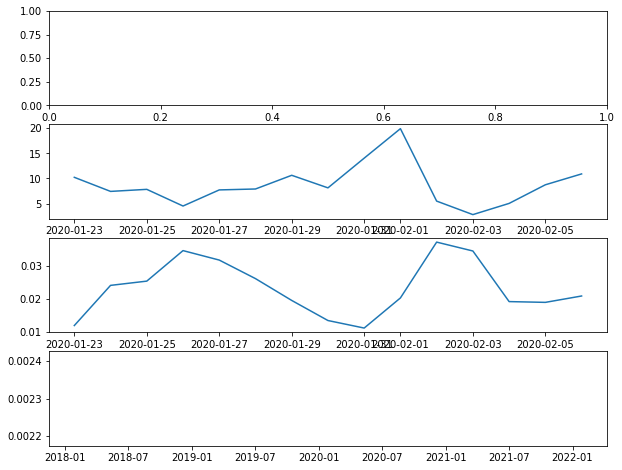

In [231]:
tfip = target_fips

#center_date = ex_dict[tfip]
center_date = pd.Timestamp('2020-01-30')

fig, axs = plt.subplots(4,1,figsize =(10,8) )
#covdf2 = load_and_augment_fips(tfip)

#cov_interval = covdf2.loc[center_date - offset:center_date+offset]
#axs[0].plot(cov_interval['daily_new_cases'])

pm20_vals = pm20df[pm20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
axs[1].plot(pm20_vals)

ozone20_vals = ozone20df[ozone20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
axs[2].plot(ozone20_vals)

lead20_vals = lead20df[lead20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
axs[3].plot(lead20_vals)

In [232]:
def dual_plot(tfip, no2df,rolling_peaks_dict):
    elist = []
    center_date = rolling_peaks_dict[tfip]
    covdf2 = load_and_augment_fips(tfip)       
    
    fig, axs = plt.subplots(2,1,figsize =(11,8), sharex=True)
    no2_vals = no2df[no2df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
    cov_interval = covdf2.loc[center_date - offset:center_date+offset]    
    title_text = "{} daily cases".format(tfip)
    axs[0].set_title(title_text)
    axs[0].plot(cov_interval["daily_new_cases"],'b',label="daily cases")
    # axs[0].plot(cov_interval["daily_new_cases"].shift(-7,freq="D"),'r', label="shifted back 7 days")
    axs[0].legend()
    axs[1].plot(no2_vals)
    axs[1].set_title("Pollutant concentrations")
    # fig.update_layout(
    #         autosize=False,
    #         width=1300,
    #         height=1100,)
    # fig.savefig(cwd.joinpath("no2_images","county_peak_plots",f"{tfip}_comparison.jpg"))
    # plt.close()

Text(0.5, 1.0, 'ozone concentrations')

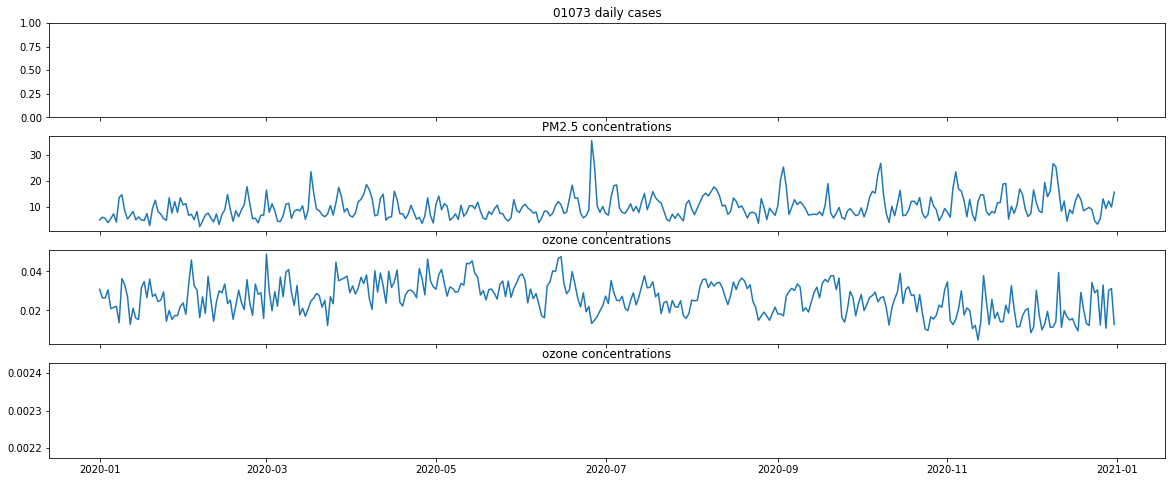

In [390]:
tfip = "01073"

#covdf2 = load_and_augment_fips(tfip)
fig, axs = plt.subplots(4,1,figsize =(20,8), sharex=True)
pm20_vals = pm20df[pm20df['fips'] == tfip]["Arithmetic Mean"]
ozone20_vals = ozone20df[ozone20df['fips'] == tfip]["Arithmetic Mean"]

title_text = "{} daily cases".format(tfip)

axs[0].set_title(title_text)
#axs[0].plot(covdf2["daily_new_cases"],'b',label="daily cases")

axs[1].plot(pm20_vals)
axs[1].set_title("PM2.5 concentrations")

axs[2].plot(ozone20_vals)
axs[2].set_title("ozone concentrations")

axs[3].plot(lead20_vals)
axs[3].set_title("ozone concentrations")

# fig.savefig(cwd.joinpath("no2_images","test",f"{tfip}_comparison.jpg"))
# plt.close()

# ------- different look -----

In [244]:
#give fips, get county

def get_county_name(df,fips_code):
    countyName = df[df['fips'] == fips_code]
    countyName = pd.DataFrame(countyName, columns = ['County Name','fips'])
    return pd.unique(countyName['County Name'])


#give county, get fips
def get_fips(df,county_name):
    fips_df = df[df['County Name'] == county_name]
    fips_df = pd.DataFrame(fips_df, columns = ['fips','County Name'])
    return pd.unique(fips_df['fips'])

In [245]:
#pm counties
pm19_counties = pm19['County Name'].unique()
pm20_counties = pm20['County Name'].unique()
pm21_counties = pm21['County Name'].unique()

#ozone counties
ozone19_counties = ozone19['County Name'].unique()
ozone20_counties = ozone20['County Name'].unique()
ozone21_counties = ozone21['County Name'].unique()

#lead counties
lead19_counties = lead19['County Name'].unique()
lead20_counties = lead20['County Name'].unique()
lead21_counties = lead21['County Name'].unique()

#pm fips
pm19_fips = pm19['fips'].unique()
pm20_fips = pm20['fips'].unique()
pm21_fips = pm21['fips'].unique()

#ozone fips 
ozone19_fips = ozone19['fips'].unique()
ozone20_fips = ozone20['fips'].unique()
ozone21_fips = ozone21['fips'].unique()

#lead fips
lead19_fips = lead19['fips'].unique()
lead20_fips = lead20['fips'].unique()
lead21_fips = lead21['fips'].unique()

In [246]:
def condense_df(df):
    df = pd.DataFrame(df, columns = ['fips','County Name','Date Local','Arithmetic Mean'])
    return df

def collect_single_fips(df,fips):
    df_result = df[df['fips'] == fips]
    return df_result

def condense_single_fips(df,fips):
    df = pd.DataFrame(df, columns = ['fips','County Name','Date Local','Arithmetic Mean'])
    df_result = df[df['fips'] == fips]
    return df_result

def add_avg_mean_month(df):
    
    return df

In [247]:
print(pm20_counties[0:5])
print(pm20_fips[0:5])

['Baldwin' 'Clay' 'DeKalb' 'Etowah' 'Jefferson']
<StringArray>
['01003', '01027', '01049', '01055', '01073']
Length: 5, dtype: string


In [248]:
#pm
print(' pm')
print('2019 county name count: ',len(pm19_counties),'& 2019 fips count: ', len(pm19_fips));
print('2020 county name count: ',len(pm20_counties),'& 2020 fips count: ', len(pm20_fips));
print('2021 county name count: ',len(pm21_counties),'& 2021 fips count: ', len(pm21_fips));

#ozone
print('\n ozone')
print('2019 county name count: ', len(ozone19_counties),'& 2019 fips count: ',len(ozone19_fips));
print('2020 county name count: ', len(ozone20_counties),'& 2020 fips count: ',len(ozone20_fips));
print('2021 county name count: ', len(ozone21_counties),'& 2021 fips count: ',len(ozone21_fips));

#lead
print('\n lead')
print('2019 county name count: ', len(lead19_counties),'& 2019 fips count: ', len(lead19_fips));
print('2020 county name count: ', len(lead20_counties),'& 2020 fips count: ', len(lead20_fips));
print('2021 county name count: ', len(lead21_counties),'& 2021 fips count: ', len(lead21_fips));


 pm
2019 county name count:  525 & 2019 fips count:  634
2020 county name count:  518 & 2020 fips count:  626
2021 county name count:  266 & 2021 fips count:  308

 ozone
2019 county name count:  621 & 2019 fips count:  776
2020 county name count:  613 & 2020 fips count:  767
2021 county name count:  349 & 2021 fips count:  408

 lead
2019 county name count:  77 & 2019 fips count:  80
2020 county name count:  69 & 2020 fips count:  71
2021 county name count:  18 & 2021 fips count:  19


In [348]:
print(get_county_name(pm20,'01073'),'\n')
print(get_fips(pm20,'Jefferson'))

['Jefferson'] 

<StringArray>
['01073', '21111', '22051', '29099', '39081', '48245']
Length: 6, dtype: string


In [349]:
target_fips = '01073' #sanfran 06075 #denver 08031

#pm
pm20_dates = list(to_cross_ref_pm20[target_fips]['Date Local'].values())
print('pm data count: ', len(pm20_dates))

#ozone
ozone20_dates = list(to_cross_ref_ozone20[target_fips]['Date Local'].values())
print('ozone data count: ', len(ozone20_dates))

#lead
lead20_dates = list(to_cross_ref_lead20[target_fips]['Date Local'].values())
print('lead data count: ', len(lead20_dates))

pm data count:  6
ozone data count:  0


KeyError: '01073'

In [276]:
## changing target fip will all data

In [350]:
target_fip = '01073'

#pm19_fip = pm19_single_fips_condensed #['fips','County Name','Date Local','Arithmetic Mean']

#pm
pm19_fip = condense_single_fips(pm19,target_fip).drop(['fips'],axis=1)
pm20_fip = condense_single_fips(pm20,target_fip).drop(['fips'],axis=1)
pm21_fip = condense_single_fips(pm21,target_fip).drop(['fips'],axis=1)

#ozone
ozone19_fip = condense_single_fips(ozone19,target_fip).drop(['fips'],axis=1)
ozone20_fip = condense_single_fips(ozone20,target_fip).drop(['fips'],axis=1)
ozone21_fip = condense_single_fips(ozone21,target_fip).drop(['fips'],axis=1)

#lead
lead19_fip = condense_single_fips(lead19,target_fip).drop(['fips'],axis=1)
lead20_fip = condense_single_fips(lead20,target_fip).drop(['fips'],axis=1)
lead21_fip = condense_single_fips(lead21,target_fip).drop(['fips'],axis=1)

### count dates for given fips

In [351]:
#pm date count
print('pm19 date count: ',len(pm19_fip['Date Local']))
print('pm20 date count: ',len(pm20_fip['Date Local']))
print('pm21 date count: ',len(pm21_fip['Date Local']))

#ozone date count
print('\nozone19 date count: ',len(ozone19_fip['Date Local']))
print('ozone20 date count: ',len(ozone20_fip['Date Local']))
print('ozone21 date count: ',len(ozone21_fip['Date Local']))

#lead date count
print('\nlead19 date count: ',len(lead19_fip['Date Local']))
print('lead20 date count: ',len(lead20_fip['Date Local']))
print('lead21 date count: ',len(lead21_fip['Date Local']))

pm19 date count:  1446
pm20 date count:  1247
pm21 date count:  205

ozone19 date count:  1502
ozone20 date count:  1523
ozone21 date count:  59

lead19 date count:  0
lead20 date count:  0
lead21 date count:  0


#### set date local as index

In [352]:

#set Date as index
#pm20.Date = pd.to_datetime(df.Date)
#df_date = df.set_index('Date', inplace=False)

pm19_fip = pm19_fip.set_index('Date Local', inplace=False)
pm20_fip = pm20_fip.set_index('Date Local', inplace=False)
pm21_fip = pm21_fip.set_index('Date Local', inplace=False)

ozone19_fip = ozone19_fip.set_index('Date Local', inplace=False)
ozone20_fip = ozone20_fip.set_index('Date Local', inplace=False)
ozone21_fip = ozone21_fip.set_index('Date Local', inplace=False)

lead19_fip = lead19_fip.set_index('Date Local', inplace=False)
lead20_fip = lead20_fip.set_index('Date Local', inplace=False)
lead21_fip = lead21_fip.set_index('Date Local', inplace=False)

### averages for each month for a single fips

In [357]:
test = pm20_fip
monthly_test = test.groupby(pd.TimeGrouper(freq='M'))

AttributeError: module 'pandas' has no attribute 'TimeGrouper'

In [363]:
#get monthly mean
pm19_month_avg = pm19_fip.resample('M').mean()
pm20_month_avg = pm20_fip.resample('M').mean()
pm21_month_avg = pm21_fip.resample('M').mean()

ozone19_month_avg = ozone19_fip.resample('M').mean()
ozone20_month_avg = ozone20_fip.resample('M').mean()
ozone21_month_avg = ozone21_fip.resample('M').mean()

lead19_month_avg = lead19_fip.resample('M').mean()
lead20_month_avg = lead20_fip.resample('M').mean()
lead21_month_avg = lead21_fip.resample('M').mean()

#group months
#df_monthly_mean = df_month.groupby(df_daily.index.month).mean()
#test = pm20_month_avg.groupby(pm20_fip.index).mean()

In [364]:
print('pm20: \n', pm20_month_avg.head(3))
print('\nozone20: \n', ozone20_month_avg.head(3))
print('\nlead20: ', lead20_month_avg.head(3))

pm20: 
             Arithmetic Mean
Date Local                 
2020-01-31         7.337859
2020-02-29         7.246267
2020-03-31         9.171109

ozone20: 
             Arithmetic Mean
Date Local                 
2020-01-31         0.024208
2020-02-29         0.024987
2020-03-31         0.029085

lead20:  Empty DataFrame
Columns: [County Name, Arithmetic Mean]
Index: []


In [355]:
pm20_month_avg

,Arithmetic Mean
Date Local,
2020-01-31,7.337859
2020-02-29,7.246267
2020-03-31,9.171109
2020-04-30,8.731114
2020-05-31,7.860870
2020-06-30,12.130129
2020-07-31,9.519681
2020-08-31,9.879171
2020-09-30,9.549745


In [385]:
def plot_all(df1,df2,df3):
    fig, (plot1, plot2, plot3) = plt.subplots(3,1,figsize =(10,8))#sharex=True

    plot1.scatter(df1.index, df1['Arithmetic Mean'],s=25, color='red')
    plot1.plot(df1.index, df1['Arithmetic Mean'],linestyle='solid',color='red')

    plot2.scatter(df2.index, df2['Arithmetic Mean'],s=25, color='blue')
    plot2.plot(df2.index, df2['Arithmetic Mean'],linestyle='solid',color='blue')

    plot3.scatter(df3.index, df3['Arithmetic Mean'],s=25, color='green')
    plot3.plot(df3.index, df3['Arithmetic Mean'],linestyle='solid',color='green')

    #plot4.scatter([df1.index, df2.index, df3.index], [df1['Arithmetic Mean'], df2['Arithmetic Mean'], df3['Arithmetic Mean']], color=('violet'), s = 10)

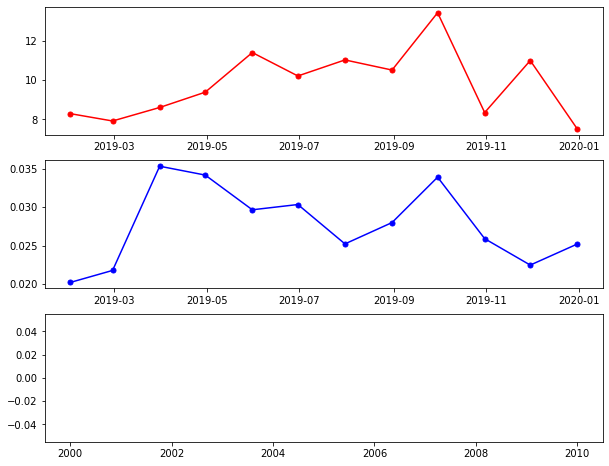

In [386]:
plot_all(pm19_month_avg,ozone19_month_avg,lead19_month_avg)

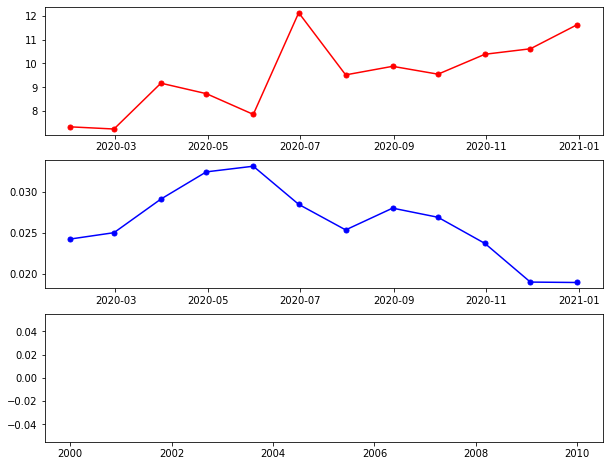

In [387]:
plot_all(pm20_month_avg,ozone20_month_avg,lead20_month_avg)

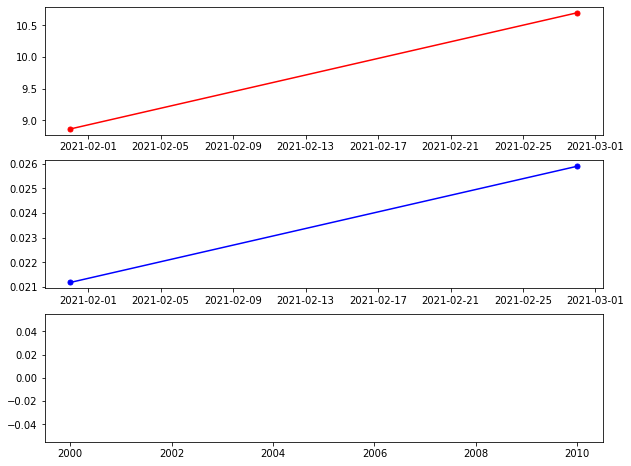

In [388]:
plot_all(pm21_month_avg,ozone21_month_avg,lead21_month_avg)

### county avg

In [299]:
pm20_fip.columns

Index(['County Name', 'Arithmetic Mean'], dtype='object')

In [289]:
test =(pm20_fip.loc[pm20_fip.index == '2020-02-29', 'Arithmetic Mean']).mean()

make a function that collects, condenses, and take the monthly average for given df of a single fip
then monthyl average every fips in the pollutant

In [337]:
def monthly_average_single_fips(df):
    return monthly_avg_df

In [ ]:
apply to every fips in pollutant df

In [338]:
def monthly_avg_all(df):
    return monthly_avg_df